# Tools to understand the behavior of ML algorithms - Hands-on tutorials

In this notebook, we provide step-by-step guides for geting started using 3 Microsoft Responsible AI tools that fall into two categories:

- **Model Fairness:** [Fairlearn](https://github.com/fairlearn/fairlearn)
- **Model Transparency:** [InterpretML](https://github.com/interpretml/interpret) and [ErrorAnalysis](https://github.com/microsoft/responsible-ai-widgets)

These are inspired by the example notebooks provided in each repo, and are meant to aggregate guides for all these tools under a single document to get you started as quickly as possible.

## Fairlearn

Fairlearn is an open-source Python package that empowers developers of AI systems to:

1. **Assess** their algorithms fairness using fairness metrics, namely:
      * False-positive rate difference.
      * False-negative rate difference.
      * Equalized-odds difference.
2. **Mitigate** any observed unfairness issues using two types of mitigation algorithms, namely:
      * `fairlearn.reductions.GridSearch`
      * `fairlearn.postprocessing.ThresholdOptimizer`

The goal here is to show both capabilities through a single use case: a credit card default classification problem.

### 0. Problem introduction

- **Data:** The UCI dataset, which contains data on 30,000 clients and their credit card transactions at a bank in Taiwan. In addition to static client features, the dataset contains the history of credit card bill payments between April and September 2005, as well as the balance limit of the client's credit card. 
- **Target:** predict if the client will default on a card payment in the following month, October 2005.
- **Strategy:** We first train a fairness-unaware algorithm on this dataset and show the model has fairness issues, namely a higher false-positive rate as well as a higher false-negative rate for the "male" group than for the "female" group. We then use Fairlearn to mitigate this disparity using both the `ThresholdOptimizer` and `GridSearch` algorithms.

In [1]:
# Installing fairlearn package and other required packages (if not already done)

#!pip install raiwidgets
#!pip install fairlearn
#!pip install lightgbm
#!pip install xlrd
#!pip install matplotlib

In [7]:
# General imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Data processing
from sklearn.model_selection import train_test_split

# Models
import lightgbm as lgb
from sklearn.calibration import CalibratedClassifierCV

# Fairlearn algorithms and utils
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.reductions import GridSearch, EqualizedOdds

# Metrics
from fairlearn.metrics import (
    MetricFrame,
    selection_rate, demographic_parity_difference, demographic_parity_ratio,
    false_positive_rate, false_negative_rate,
    false_positive_rate_difference, false_negative_rate_difference,
    equalized_odds_difference)
from sklearn.metrics import balanced_accuracy_score, roc_auc_score

In [12]:
# Load the data
data_url = "http://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
dataset = pd.read_excel(io=data_url, header=1).drop(columns=['ID']).rename(columns={'PAY_0':'PAY_1'})
dataset.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


Dataset columns:

* `LIMIT_BAL`: credit card limit, will be replaced by a synthetic feature
* `SEX, EDUCATION, MARRIAGE, AGE`: client demographic features
* `BILL_AMT[1-6]`: amount on bill statement for April-September
* `PAY_AMT[1-6]`: payment amount for April-September
* `default payment next month`: target, whether the client defaulted the following month

In [13]:
# Extract the sensitive feature
A = dataset["SEX"]
A_str = A.map({ 2:"female", 1:"male"})
# Extract the target
Y = dataset["default payment next month"]
categorical_features = ['EDUCATION', 'MARRIAGE','PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
sensitive_features = dataset[['SEX']]
for col in categorical_features:
    dataset[col] = dataset[col].astype('category')

**Introducing a biased Synthetic Feature:** We manipulate the balance-limit feature `LIMIT_BAL` to make it highly predictive for the "female" group but not for the "male" group. Specifically, we set this up, so that a lower credit limit indicates that a female client is less likely to default, but provides no information on a male client's probability of default.

In [14]:
dist_scale = 0.5
np.random.seed(12345)
# Make 'LIMIT_BAL' informative of the target
dataset['LIMIT_BAL'] = Y + np.random.normal(scale=dist_scale, size=dataset.shape[0])
# But then make it uninformative for the male clients
dataset.loc[A==1, 'LIMIT_BAL'] = np.random.normal(scale=dist_scale, size=dataset[A==1].shape[0])

In [15]:
# Train-test split
df_train, df_test, Y_train, Y_test, A_train, A_test, A_str_train, A_str_test, sensitive_features_train, sensitive_features_test = train_test_split(
    dataset.drop(columns=['SEX', 'default payment next month']), 
    Y, 
    A, 
    A_str,
    sensitive_features,
    test_size = 0.3, 
    random_state=12345,
    stratify=Y)

In [16]:
# Some helper functions to be used later
def get_metrics_df(models_dict, y_true, group):
    metrics_dict = {
        "Overall selection rate": (
            lambda x: selection_rate(y_true, x), True),
        "Demographic parity difference": (
            lambda x: demographic_parity_difference(y_true, x, sensitive_features=group), True),
        "Demographic parity ratio": (
            lambda x: demographic_parity_ratio(y_true, x, sensitive_features=group), True),
        "------": (lambda x: "", True),
        "Overall balanced error rate": (
            lambda x: 1-balanced_accuracy_score(y_true, x), True),
        "Balanced error rate difference": (
            lambda x: MetricFrame(balanced_accuracy_score, y_true, x, sensitive_features=group).difference(method='between_groups'), True),
        " ------": (lambda x: "", True),
        "False positive rate difference": (
            lambda x: false_positive_rate_difference(y_true, x, sensitive_features=group), True),
        "False negative rate difference": (
            lambda x: false_negative_rate_difference(y_true, x, sensitive_features=group), True),
        "Equalized odds difference": (
            lambda x: equalized_odds_difference(y_true, x, sensitive_features=group), True),
        "  ------": (lambda x: "", True),
        "Overall AUC": (
            lambda x: roc_auc_score(y_true, x), False),
        "AUC difference": (
            lambda x: MetricFrame(roc_auc_score, y_true, x, sensitive_features=group).difference(method='between_groups'), False),
    }
    df_dict = {}
    for metric_name, (metric_func, use_preds) in metrics_dict.items():
        df_dict[metric_name] = [metric_func(preds) if use_preds else metric_func(scores) 
                                for model_name, (preds, scores) in models_dict.items()]
    return pd.DataFrame.from_dict(df_dict, orient="index", columns=models_dict.keys())

### 1. Assessing unfairness

We first train an out-of-the-box lightgbm model on the modified data and assess several fairness metrics.

In [17]:
lgb_params = {
    'objective' : 'binary',
    'metric' : 'auc',
    'learning_rate': 0.03,
    'num_leaves' : 10,
    'max_depth' : 3
}
model = lgb.LGBMClassifier(**lgb_params)
model.fit(df_train, Y_train)

LGBMClassifier(learning_rate=0.03, max_depth=3, metric='auc', num_leaves=10,
               objective='binary')

In [18]:
# Scores on test set
test_scores = model.predict_proba(df_test)[:, 1]
# Predictions (0 or 1) on test set
test_preds = (test_scores >= np.mean(Y_train)) * 1
# Metrics
models_dict = {"Unmitigated": (test_preds, test_scores)}
get_metrics_df(models_dict, Y_test, A_str_test)

You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.


,Unmitigated
Overall selection rate,0.268111
Demographic parity difference,0.051105
Demographic parity ratio,0.8225
------,
Overall balanced error rate,0.220682
Balanced error rate difference,0.175789
------,
False positive rate difference,0.009296
False negative rate difference,0.342283
Equalized odds difference,0.342283


In [ ]:
# IMPORTANT NOTE: please only run this cell is you have correctly intalled the raiwidgets library, if not you can still run the rest of the notebook's cells and skip this visualization with no problem.
from raiwidgets import FairnessDashboard
Y_pred = model.predict(df_test)
FairnessDashboard(sensitive_features=sensitive_features_test,
                  y_true=Y_test,
                  y_pred=Y_pred)

**Remarks:**
- As the overall **performance metric** we use the _area under ROC curve_ (AUC), which is suited to classification problems with a large imbalance between positive and negative examples. For binary classifiers, this is the same as _balanced accuracy_.

- As the **fairness metric** we use *equalized odds difference*, which quantifies the disparity in accuracy experienced by different demographics. Our goal is to assure that neither of the two groups ("male" vs "female") has substantially larger false-positive rates or false-negative rates than the other group. The equalized odds difference is equal to the larger of the following two numbers: (1) the difference between false-positive rates of the two groups, (2) the difference between false-negative rates of the two groups. The closer to zero the Equalized odds difference is, the better.

The table above shows the overall AUC of 0.85 (based on continuous predictions) and the overall balanced error rate of 0.22 (based on 0/1 predictions). Both of these are satisfactory in our application context. However, there is a large disparity in accuracy rates (as indicated by the balanced error rate difference) and even larger when we consider the equalized-odds difference. As a sanity check, we also show the demographic parity ratio, whose level (slightly above 0.8) is considered satisfactory in this context.

Now that we detected that there is indeed a fairness issue, let's see how we can mitigate it.

### 2. Mititgating unfairness issues

#### Mitigating Equalized Odds Difference with Postprocessing

We attempt to mitigate the disparities in the `lightgbm` predictions using the Fairlearn postprocessing algorithm `ThresholdOptimizer`. This algorithm finds a suitable threshold for the scores (class probabilities) produced by the `lightgbm` model by optimizing the accuracy rate under the constraint that the equalized odds difference (on training data) is zero. Since our goal is to optimize balanced accuracy, we resample the training data to have the same number of positive and negative examples. This means that `ThresholdOptimizer` is effectively optimizing balanced accuracy on the original data.

In [19]:
postprocess_est = ThresholdOptimizer(
    estimator=model,
    constraints="equalized_odds",
    prefit=True)

# Balanced data set is obtained by sampling the same number of points from the majority class (Y=0)
# as there are points in the minority class (Y=1)
balanced_idx1 = df_train[Y_train==1].index
pp_train_idx = balanced_idx1.union(Y_train[Y_train==0].sample(n=balanced_idx1.size, random_state=1234).index)

df_train_balanced = df_train.loc[pp_train_idx, :]
Y_train_balanced = Y_train.loc[pp_train_idx]
A_train_balanced = A_train.loc[pp_train_idx]

postprocess_est.fit(df_train_balanced, Y_train_balanced, sensitive_features=A_train_balanced)

postprocess_preds = postprocess_est.predict(df_test, sensitive_features=A_test)
models_dict = {"Unmitigated": (test_preds, test_scores),
              "ThresholdOptimizer": (postprocess_preds, postprocess_preds)}
get_metrics_df(models_dict, Y_test, A_str_test)

'predict_method' default value is changed from 'predict' to 'auto'. Explicitly pass `predict_method='predict' to replicate the old behavior, or pass `predict_method='auto' or other valid values to silence this warning.
You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.


,Unmitigated,ThresholdOptimizer
Overall selection rate,0.268111,0.080778
Demographic parity difference,0.051105,0.005265
Demographic parity ratio,0.8225,0.937323
------,,
Overall balanced error rate,0.220682,0.406107
Balanced error rate difference,0.175789,0.007486
------,,
False positive rate difference,0.009296,0.002053
False negative rate difference,0.342283,0.012919
Equalized odds difference,0.342283,0.012919


We observe that the `ThresholdOptimizer` algorithm significantly reduces the disparity according to multiple metrics. However, the performance metrics (balanced error rate as well as AUC) get worse. Before deploying such a model in practice, it would be important to examine in more detail why we observe such a sharp trade-off. In our case it is because the available features are much less informative for one of the demographic groups than for the other.

Note that unlike the unmitigated model, `ThresholdOptimizer` produces 0/1 predictions, so its balanced error rate difference is equal to the AUC difference, and its overall balanced error rate is equal to 1 - overall AUC.

#### Mitigating Equalized Odds Difference with GridSearch

We now attempt to mitigate disparities using the `GridSearch` algorithm. Unlike `ThresholdOptimizer`, the predictors produced by `GridSearch` do not access the sensitive feature at test time. Also, rather than training a single model, we train multiple models corresponding to different trade-off points between the performance metric (balanced accuracy) and fairness metric (equalized odds difference).

In [20]:
# Train GridSearch
sweep = GridSearch(model,
                   constraints=EqualizedOdds(),
                   grid_size=50,
                   grid_limit=3)

sweep.fit(df_train_balanced, Y_train_balanced, sensitive_features=A_train_balanced)

Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Finished loading model, total used 100 iterations
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Finished loading model, total used 100 iterations
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Finished loading model, total used 100 iterations
Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
Finished loading model, total used 100 iterations
Using the level keyword in DataFrame

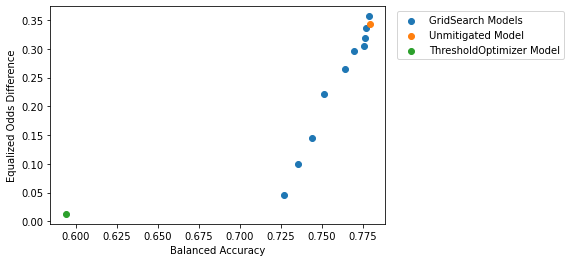

In [21]:
sweep_preds = [predictor.predict(df_test) for predictor in sweep.predictors_] 
sweep_scores = [predictor.predict_proba(df_test)[:, 1] for predictor in sweep.predictors_] 

equalized_odds_sweep = [
    equalized_odds_difference(Y_test, preds, sensitive_features=A_str_test)
    for preds in sweep_preds
]
balanced_accuracy_sweep = [balanced_accuracy_score(Y_test, preds) for preds in sweep_preds]
auc_sweep = [roc_auc_score(Y_test, scores) for scores in sweep_scores]

# Select only non-dominated models (with respect to balanced accuracy and equalized odds difference)
all_results = pd.DataFrame(
    {"predictor": sweep.predictors_, "accuracy": balanced_accuracy_sweep, "disparity": equalized_odds_sweep}
) 
non_dominated = [] 
for row in all_results.itertuples(): 
    accuracy_for_lower_or_eq_disparity = all_results["accuracy"][all_results["disparity"] <= row.disparity] 
    if row.accuracy >= accuracy_for_lower_or_eq_disparity.max(): 
        non_dominated.append(True)
    else:
        non_dominated.append(False)

equalized_odds_sweep_non_dominated = np.asarray(equalized_odds_sweep)[non_dominated]
balanced_accuracy_non_dominated = np.asarray(balanced_accuracy_sweep)[non_dominated]
auc_non_dominated = np.asarray(auc_sweep)[non_dominated]

# Plot equalized odds difference vs balanced accuracy
plt.scatter(balanced_accuracy_non_dominated, equalized_odds_sweep_non_dominated, label="GridSearch Models")
plt.scatter(balanced_accuracy_score(Y_test, test_preds),
            equalized_odds_difference(Y_test, test_preds, sensitive_features=A_str_test), 
            label="Unmitigated Model")
plt.scatter(balanced_accuracy_score(Y_test, postprocess_preds), 
            equalized_odds_difference(Y_test, postprocess_preds, sensitive_features=A_str_test),
            label="ThresholdOptimizer Model")
plt.xlabel("Balanced Accuracy")
plt.ylabel("Equalized Odds Difference")
plt.legend(bbox_to_anchor=(1.55, 1))
plt.show()

In [22]:
# Compare GridSearch models with low values of equalized odds difference with the previously constructed models
grid_search_dict = {"GridSearch_{}".format(i): (sweep_preds[i], sweep_scores[i])
                    for i in range(len(sweep_preds))
                    if non_dominated[i] and equalized_odds_sweep[i]<0.1}
models_dict.update(grid_search_dict)
get_metrics_df(models_dict, Y_test, A_str_test)

You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
You have provided 'metrics', '

,Unmitigated,ThresholdOptimizer,GridSearch_39,GridSearch_40
Overall selection rate,0.268111,0.080778,0.268667,0.256
Demographic parity difference,0.051105,0.005265,0.020546,0.03327
Demographic parity ratio,0.8225,0.937323,0.926947,0.87962
------,,,,
Overall balanced error rate,0.220682,0.406107,0.264572,0.273208
Balanced error rate difference,0.175789,0.007486,0.066646,0.040527
------,,,,
False positive rate difference,0.009296,0.002053,0.034358,0.035793
False negative rate difference,0.342283,0.012919,0.098935,0.045262
Equalized odds difference,0.342283,0.012919,0.098935,0.045262


### 3. Fairlearn tutorial conclusion

In this Fairlearn tutorial, we explored how a fairness-unaware model performed on the classification task in contrast to the postprocessed `ThresholdOptimizer` model and the `GridSearch` model. The `ThresholdOptimizer` greatly reduced the disparity in performance across multiple fairness metrics. However the overall error rate and AUC for the `ThresholdOptimizer` model were worse compared to the fairness-unaware model. 

With the `GridSearch` algorithm, we trained multiple models that balance the trade-off between the balanced accuracy and the equalized odds fairness metric. After engaging with relevant stakeholders, the data scientist can deploy the model that balances the performance-fairness trade-off that meets the needs of the business.

## InterpretML

InterpretML is an open-source package (the interpret Python package) that incorporates state-of-the-art machine learning interpretability techniques under one roof, with a unified API and a built-in visualization platform. InterpretML helps you understand your model's global behavior or understand the reasons behind individual predictions. The package exposes two types of interpretability:

- **Blackbox explainability**, which consists of techniques for explaining existing machine learning models (ex: Partial Dependence, LIME) 
- **Glassbox interpretability**, which are machine learning models designed for interpretability (ex: linear models, rule lists, generalized additive models). InterpretML also includes the first implementation of the Explainable Boosting Machine, a powerful, interpretable, glassbox model that can be as accurate as many blackbox models.

We illustrate each of these two type of interpretability using seperate use cases below.

### Explaining Blackbox Classifiers

In this section of the tutorial, We show how blackbox model explainability works using a simple binary classification example which consists of predicting income (more or less than 50k) using a Random Forest classifier.

We first load the data and have a first look at it.

In [23]:
# Useful imports and data loading 
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    header=None)
df.columns = [
    "Age", "WorkClass", "fnlwgt", "Education", "EducationNum",
    "MaritalStatus", "Occupation", "Relationship", "Race", "Gender",
    "CapitalGain", "CapitalLoss", "HoursPerWeek", "NativeCountry", "Income"
]
# Use this line to work on a very small fraction of the dataset
df = df.sample(frac=0.01, random_state=1)
train_cols = df.columns[0:-1]
label = df.columns[-1]
X = df[train_cols]
y = df[label].apply(lambda x: 0 if x == " <=50K" else 1) #Turning response into 0 and 1

# We have to transform categorical variables to use sklearn models
X_enc = pd.get_dummies(X, prefix_sep='.')
feature_names = list(X_enc.columns)

seed = 1  
X_train, X_test, y_train, y_test = train_test_split(X_enc, y, test_size=0.20, random_state=seed)
df.head()

,Age,WorkClass,fnlwgt,Education,EducationNum,MaritalStatus,Occupation,Relationship,Race,Gender,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,Income
9646,62,Self-emp-not-inc,26911,7th-8th,4,Widowed,Other-service,Not-in-family,White,Female,0,0,66,United-States,<=50K
709,18,Private,208103,11th,7,Never-married,Other-service,Other-relative,White,Male,0,0,25,United-States,<=50K
7385,25,Private,102476,Bachelors,13,Never-married,Farming-fishing,Own-child,White,Male,27828,0,50,United-States,>50K
16671,33,Private,511517,HS-grad,9,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,<=50K
21932,36,Private,292570,11th,7,Never-married,Machine-op-inspct,Unmarried,White,Female,0,0,40,United-States,<=50K


We now train a blackbox RF classifier after some dimensionality reduction with PCA.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

#Blackbox system can include preprocessing, not just a classifier!
pca = PCA()
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)

blackbox_model = Pipeline([('pca', pca), ('rf', rf)])
blackbox_model.fit(X_train, y_train)

Now we use all InterpretML blackbox explainability techniques (see in-code comments for details) and we compare them all in a unified dashboard.

In [ ]:
# 1. Blackbox model performance
from interpret import show
from interpret.perf import ROC

blackbox_perf = ROC(blackbox_model.predict_proba).explain_perf(X_test, y_test, name='Blackbox')

# 2. Local Explanations
from interpret.blackbox import LimeTabular
from interpret import show

#Blackbox explainers need a predict function, and optionally a dataset
lime = LimeTabular(predict_fn=blackbox_model.predict_proba, data=X_train, random_state=1)

#Pick the instances to explain, optionally pass in labels if you have them
lime_local = lime.explain_local(X_test[:5], y_test[:5], name='LIME')


from interpret.blackbox import ShapKernel
import numpy as np

background_val = np.median(X_train, axis=0).reshape(1, -1)
shap = ShapKernel(predict_fn=blackbox_model.predict_proba, data=background_val, feature_names=feature_names)
shap_local = shap.explain_local(X_test[:5], y_test[:5], name='SHAP')

# 3. Global Explanations
from interpret.blackbox import MorrisSensitivity

sensitivity = MorrisSensitivity(predict_fn=blackbox_model.predict_proba, data=X_train)
sensitivity_global = sensitivity.explain_global(name="Global Sensitivity")

from interpret.blackbox import PartialDependence

pdp = PartialDependence(predict_fn=blackbox_model.predict_proba, data=X_train)
pdp_global = pdp.explain_global(name='Partial Dependence')

# Show them all in one dashboard
show([blackbox_perf, lime_local, shap_local, sensitivity_global, pdp_global])

### Interpretable glassbox classification using EBM

In this tutorial, we use the same UCI Adult dataste used in the previous one. The goal is to show tat EBM are interpretable by design and ar better in terms of performance than other gassbox models.

#### EBM is interpretable by design

In [ ]:
from interpret.glassbox import ExplainableBoostingClassifier, LogisticRegression, ClassificationTree, DecisionListClassifier
from interpret.perf import ROC


# Use the same data as before
seed = 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed)

# Train EBM
ebm = ExplainableBoostingClassifier(random_state=seed, n_jobs=-1)
ebm.fit(X_train, y_train)   #Works on dataframes and numpy arrays

# Global explanations
ebm_global = ebm.explain_global(name='EBM')
ebm_local = ebm.explain_local(X_test[:5], y_test[:5], name='EBM')
ebm_perf = ROC(ebm.predict_proba).explain_perf(X_test, y_test, name='EBM')

show([ebm_global, ebm_local, ebm_perf])

#### EBM has better performance than other glassbox models

In [ ]:
from interpret.glassbox import LogisticRegression, ClassificationTree

# We have to transform categorical variables to use Logistic Regression and Decision Tree
X_enc = pd.get_dummies(X, prefix_sep='.')
feature_names = list(X_enc.columns)
X_train_enc, X_test_enc, y_train, y_test = train_test_split(X_enc, y, test_size=0.20, random_state=seed)

lr = LogisticRegression(random_state=seed, feature_names=feature_names, penalty='l1', solver='liblinear')
lr.fit(X_train_enc, y_train)

tree = ClassificationTree()
tree.fit(X_train_enc, y_train)

lr_perf = ROC(lr.predict_proba).explain_perf(X_test_enc, y_test, name='Logistic Regression')
tree_perf = ROC(tree.predict_proba).explain_perf(X_test_enc, y_test, name='Classification Tree')
lr_global = lr.explain_global(name='Logistic Regression')
tree_global = tree.explain_global(name='Classification Tree')
show([lr_global, lr_perf, tree_global, tree_perf, ebm_global, ebm_perf], share_tables=True)

Under the performance tab, we can see that EBM achieves much higher performance (in terms of AUC) than other glassbox models.

## Error Analysis

Error Analysis is an open-source Responsible AI toolkit that enables you to get a deeper understanding of machine learning model errors. When evaluating a machine learning model, a single score like the aggregate accuracy is not sufficient to understand where the model went wrong and may hide important conditions of inaccuracies between cohorts of your data. Error Analysis allows you to: 

- **Identify** cohorts with higher error rates versus the overall benchmark and visualize how the error rate is distributed.
- **Diagnose** the root causes behind these errors.

This notebook is an adapted more concise version of the [erroranalysis-dashboard-multiclass.ipynb](https://github.com/microsoft/responsible-ai-widgets/blob/main/notebooks/erroranalysis-dashboard-multiclass.ipynb) noteook provided as part of the [open-source](https://github.com/microsoft/responsible-ai-widgets/blob/main/notebooks/erroranalysis-dashboard-multiclass.ipynb) Responsible-AI-Widgets package. 
It demonstrates how to use the Responsible AI Widget's Error Analysis dashboard to understand a model trained on the multiclass wine dataset. 

The goal is to classify types of wine with scikit-learn and explore model errors and explanations by following three steps:

1. Train an SVM classification model using Scikit-learn
2. Load simple ErrorAnalysis view without explanations
3. Visualize model errors and global and local explanations with the Error Analysis visualization dashboard after running Interpret-Community's 'explain_model' globally and locally to generate model explanations.

### Train an SVM classification model using Scikit-learn

**Step 1:** Import required packages and load the wine data from scikit-learn.

In [ ]:
from sklearn.datasets import load_wine
from sklearn import svm

# Imports for SHAP MimicExplainer with LightGBM surrogate model
from interpret.ext.blackbox import MimicExplainer
from interpret.ext.glassbox import LGBMExplainableModel

# Loading wine data
wine = load_wine()
X = wine['data']
y = wine['target']
classes = wine['target_names']
feature_names = wine['feature_names']

**Step 2:** Training SVM classification model

In [ ]:
# Split data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

# Training the SVM model
from sklearn.linear_model import LogisticRegression
clf = svm.SVC(gamma=0.001, C=100., probability=True)
model = clf.fit(X_train, y_train)

print("number of errors on test dataset: " + str(sum(model.predict(X_test) != y_test)))

We notice that the model makes a fair number of errors, let's explore where these errors come from using the Error Analysis dashboard.

### Load simple ErrorAnalysis view without explanations

**Step 3:** Identification of errors using decision trees and error heatmaps from the ErrorAnalysis dashboard (without explanations – see next step)

In [ ]:
from raiwidgets import ErrorAnalysisDashboard
predictions = model.predict(X_test)
ErrorAnalysisDashboard(dataset=X_test, true_y=y_test, features=feature_names, pred_y=predictions)

From the Decision Tree tab of the dashboard, we clearly see from this decision tree that the biggest error rate (19 errors out of 36 predictions – more than half) occurs when the feature malic_acid is higher than 2.26. This is clearly a problem and we need to investigate this cohort more punctually, which we will do in the next step.

### Visualize model errors and global and local explanations with the Error Analysis visualization dashboard

**Step 4:** Running the Interpret-Community's 'explain_global' to generate model explanations.

In [ ]:
from interpret_community.common.constants import ModelTask
# Train the LightGBM surrogate model using MimicExplaner
model_task = ModelTask.Classification
explainer = MimicExplainer(model, X_train, LGBMExplainableModel,
                           augment_data=True, max_num_of_augmentations=10,
                           features=feature_names, classes=classes, model_task=model_task)

# Generate global explanations
global_explanation = explainer.explain_global(X_test)

**Step 5:** Analyze model errors and explanations using Error Analysis dashboard by feeding model explanations generated in step 4.

In [ ]:
from raiwidgets import ErrorAnalysisDashboard
ErrorAnalysisDashboard(global_explanation, model, dataset=X_test, true_y=y_test)

In [ ]:
This concludes this series of tutorials about tools to (better) understand the behavior of ML algorithms.